8. PULCHER/FORMOSUS (Эдуард Григорьев)

а. Найти у разных авторов количество вхождений прил “красивый”

б. Выявить их количественное соотношение и проинтерпретировать результаты.

pulcher

I pulcher, chra, chrum

1) красивый (pulchrae turpesque puellae O; urbs pulcherrima Cs);

2) прекрасный, славный, благородный (facinus Sl; mors V): quid habet pulchri? H что в нём хорошего?

Возможна омонимия с следующим значеним:

II Pulcher, chri m

Пульхр, cognomen в роде Клавдиев L, VM.

formosus, a, um [forma]

стройный, изящный, красивый, прекрасный (homo, virgo C; pecus V; domus Sen): formosum anni tempus O = весна.

Пользовался базой, выложенной на сайте http://www.thelatinlibrary.com/

In [1]:
# подключаем необходимые библиотеки
import urllib.request
import re
import unidecode
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
import numpy as np
from seaborn import barplot
import operator

In [2]:
# cкачиваем html страницы с парадигмой pulcher
url1 = 'https://en.wiktionary.org/wiki/pulcher'
req = urllib.request.Request(url1)
response = urllib.request.urlopen(req)
html1 = response.read().decode('utf-8')

In [3]:
# отбираем нужный материал в html
html1_ = re.findall('<table class=\"prettytable inflection-table\">(.*?)<\/table>', html1, re.DOTALL)[0]

In [4]:
# заводим парадигму pulcher
paradigm1 = re.findall('<span.*?>(.*?)<\/span>', html1_)

In [5]:
# убираем диакритики с помощью модуля unidecode
for i, elem in enumerate(paradigm1):
    paradigm1[i] = unidecode.unidecode(re.sub('<.*?>', '', elem))

In [6]:
# превращаем в множество, чтобы не дублировались словоформы
paradigm1 = set(paradigm1)

In [7]:
# поскольку возможно прибавление энклитики que, добавим и эти варианты в парадигму
tmp = []
for elem in paradigm1:
    tmp.append(elem + 'que')
for elem in tmp:
    paradigm1.add(elem)

In [8]:
# cкачиваем html страницы с парадигмой formosus
url2 = 'https://en.wiktionary.org/wiki/formosus'
req = urllib.request.Request(url2)
response = urllib.request.urlopen(req)
html2 = response.read().decode('utf-8')

In [9]:
# отбираем нужный материал в html
html2_ = re.findall('<table class=\"prettytable inflection-table\">(.*?)<\/table>', html2, re.DOTALL)[0]

In [10]:
# превращаем в множество, чтобы не дублировались словоформы
paradigm2 = re.findall('<span.*?>(.*?)<\/span>', html2_)

In [11]:
# убираем диакритики с помощью модуля unidecode
for i, elem in enumerate(paradigm2):
    paradigm2[i] = unidecode.unidecode(re.sub('<.*?>', '', elem))

In [12]:
# превращаем в множество, чтобы не дублировались словоформы
paradigm2 = set(paradigm2)

In [13]:
# поскольку возможно прибавление энклитики que, добавим и эти варианты в парадигму
tmp = []
for elem in paradigm2:
    tmp.append(elem + 'que')
for elem in tmp:
    paradigm2.add(elem)

In [14]:
# краулером обходим http://www.thelatinlibrary.com/
fl = 0 # флаг, чтобы в первом случае не брать последние 5 ссылок, а в остальных случаях -- только 2 (см., как устроен этот сайт)
url = 'http://www.thelatinlibrary.com/' # базовый url, к которому уже прибавляются относительные ссылки
hrefs = set() # множество, в котором будем хранить ещё не обработанные ссылки
all_ = set() # множество, содержащее те ссылки, которые мы уже обработали
hrefs.add('') # начинаем с главной страницы
texts = dict() # словарь текстов автор_произведение --> текст
urls_to_author = dict() # словарь соотношений url --> author
while hrefs: # пока есть ещё не обработанные ссылки
    print(len(hrefs)) # печатаем длину множества
    href_pop = hrefs.pop() # берём произвольный элемент из множества (с удалением из него)
    if href_pop in all_: # если мы уже его рассматривали, то переходим в начало цикла
        continue
    all_.add(href_pop) # сразу добавим в множество обработанных ссылок
    href = url + href_pop # образуем полную ссылку
    req = urllib.request.Request(href) 
    print(href) # на случай, если мы где-то нашли ссылку, которой на самом деле нет на сайте
    try:
        response = urllib.request.urlopen(req) 
    except:
        print('There is no such url') # если не нашлось, то печатаем информацию об этом
        continue # переходим в начало цикла
    html = response.read().decode('Latin-1') # html в кодировке 'Latin-1'
    authors = re.findall('([a-zA-Z\/\.0-9]+\.s?html).*?([a-zA-Z \n&;()]+).*?<', html, re.DOTALL) # список кортежей (ссылка, автор+название)
    if len(authors) == 3 or len(authors) == 4 and authors[0][0].strip('\/') in all_: # если ссылок ровно 3 (т.е. на странице просто текст произведения) или их 4, но первую из них мы уже рассматривали
        print(href_pop) # печатаем для проверки
        text = ''.join(re.findall('<p>(.*?)<\/p>', html, re.IGNORECASE | re.DOTALL)[:-1]) # объединяем абзацы в один текст
        text = text.replace('&nbsp;', '') # удаляем неразрывный пробел
        text = re.sub('<.*?>', ' ', text) # удаляем все теги с содержимым
        text = text.replace('\n', ' ').strip() # считаем, что текст единый, т.е. без переносов
        for number in '0123456789[]':
            text = text.replace(number, '')
        text = text.replace('..', '') # после удаления, например, в послед-ти '1.2.3' цифр, останутся две точки, которые можно удалить
        texts[urls_to_author[href_pop]] = text # заполняем наш словарь: по ссылке получаем автора+название, а возвращаем текст
        continue # переходим в начало цикла
    if fl == 0: # у нас исходная страница
        for i, author in enumerate(authors[:-5]): # 5 последних ссылок не рассматриваем, т.к. они не ведут на тексты
            if authors[i][0].startswith('\/'): # если ссылка начинается со слеша, то удаляем его, т.к. в url у нас уже указан конечный слеш
                authors[i][0] = author[0][1:]
            urls_to_author[authors[i][0]] = author[1].strip().replace('\n', ' ') # заполняем массив соотношений url --> author
            hrefs.add(authors[i][0]) # добавляем ссылку в необработанные
        fl = 1 # все остальные устроены иначе
    else: # не первая страница
        for i, author in enumerate(authors[:-2]): # две последние ссылки не ведут на тексты
            if authors[i][0].startswith('\/'):
                authors[i][0] = author[0][1:]
            urls_to_author[authors[i][0]] = urls_to_author[href_pop] + '_' + author[1].strip().replace('\n', ' ').replace('&nbsp;', '') # заполняем массив соотношений url --> author
            hrefs.add(authors[i][0]) # добавляем ссылку в необработанные

1
http://www.thelatinlibrary.com/
93
http://www.thelatinlibrary.com/obsequens.html
obsequens.html
92
http://www.thelatinlibrary.com/aquinas.html
98
http://www.thelatinlibrary.com/bacon.html
117
http://www.thelatinlibrary.com/martial.html
131
http://www.thelatinlibrary.com/minucius.html
minucius.html
130
http://www.thelatinlibrary.com/cato.dis.html
cato.dis.html
129
http://www.thelatinlibrary.com/misc.html
172
http://www.thelatinlibrary.com/bacon/bacon.sermones.shtml
bacon/bacon.sermones.shtml
171
http://www.thelatinlibrary.com/tertullian.html
207
http://www.thelatinlibrary.com/aquinas/princ.shtml
aquinas/princ.shtml
206
http://www.thelatinlibrary.com/bible.html
282
http://www.thelatinlibrary.com/neo.html
350
http://www.thelatinlibrary.com/paris.html
paris.html
349
http://www.thelatinlibrary.com/contemp.html
357
http://www.thelatinlibrary.com/poree.html
poree.html
356
http://www.thelatinlibrary.com/bible/songofsongs.shtml
bible/songofsongs.shtml
355
http://www.thelatinlibrary.com/sall.h

673
http://www.thelatinlibrary.com/sall.phil.html
sall.phil.html
672
http://www.thelatinlibrary.com/liv.per18.shtml
There is no such url
671
http://www.thelatinlibrary.com/liv.per34.shtml
There is no such url
670
http://www.thelatinlibrary.com/alice5.html
There is no such url
669
http://www.thelatinlibrary.com/liv.per95.shtml
There is no such url
668
http://www.thelatinlibrary.com/tertullian/tertullian.oratione.shtml
tertullian/tertullian.oratione.shtml
667
http://www.thelatinlibrary.com/bible/prologi.shtml
bible/prologi.shtml
666
http://www.thelatinlibrary.com/justinian/digest5.shtml
665
http://www.thelatinlibrary.com/liv.per110.shtml
There is no such url
664
http://www.thelatinlibrary.com/liv.per133.shtml
There is no such url
663
http://www.thelatinlibrary.com/ammianus.html
680
http://www.thelatinlibrary.com/livy/liv.26.shtml
livy/liv.26.shtml
679
http://www.thelatinlibrary.com/liv.per118.shtml
There is no such url
678
http://www.thelatinlibrary.com/liv.per102.shtml
There is no such 

bible/hebrews.shtml
760
http://www.thelatinlibrary.com/justinian/digest17.shtml
759
http://www.thelatinlibrary.com/bible/nahum.html
758
http://www.thelatinlibrary.com/eutropius/eutropius10.shtml
eutropius/eutropius10.shtml
757
http://www.thelatinlibrary.com/justinian/digest33.shtml
756
http://www.thelatinlibrary.com/justinian/digest29.shtml
755
http://www.thelatinlibrary.com/forsett.html
756
http://www.thelatinlibrary.com/sall.lep.html
sall.lep.html
755
http://www.thelatinlibrary.com/liv.per35.shtml
There is no such url
754
http://www.thelatinlibrary.com/avienus.periegesis.html
avienus.periegesis.html
753
http://www.thelatinlibrary.com/tertullian/tertullian.castitatis.shtml
tertullian/tertullian.castitatis.shtml
752
http://www.thelatinlibrary.com/liv.per58.shtml
There is no such url
751
http://www.thelatinlibrary.com/statius/theb3.shtml
statius/theb3.shtml
750
http://www.thelatinlibrary.com/liv.per117.shtml
There is no such url
749
http://www.thelatinlibrary.com/jerome/vitamalchus.html

vitacaroli.html
898
http://www.thelatinlibrary.com/maximianus.html
maximianus.html
897
http://www.thelatinlibrary.com/justinian/digest42.shtml
896
http://www.thelatinlibrary.com/liv.per89.shtml
There is no such url
895
http://www.thelatinlibrary.com/prud.html
909
http://www.thelatinlibrary.com/justinian/digest44.shtml
908
http://www.thelatinlibrary.com/martial/mart.spec.shtml
martial/mart.spec.shtml
907
http://www.thelatinlibrary.com/juvenal/2.shtml
juvenal/2.shtml
906
http://www.thelatinlibrary.com/justin/21.html
justin/21.html
905
http://www.thelatinlibrary.com/1644.html
904
http://www.thelatinlibrary.com/erasmus/ep.shtml
erasmus/ep.shtml
903
http://www.thelatinlibrary.com/liv.per37.shtml
There is no such url
902
http://www.thelatinlibrary.com/gregorytours.html
911
http://www.thelatinlibrary.com/prec.terr.html
prec.terr.html
910
http://www.thelatinlibrary.com/spinoza.html
914
http://www.thelatinlibrary.com/bible/zacharias.html
913
http://www.thelatinlibrary.com/aquinas/p1.shtml
993
h

1006
http://www.thelatinlibrary.com/baldo.html
baldo.html
1005
http://www.thelatinlibrary.com/regula.html
1004
http://www.thelatinlibrary.com/livy/liv.1.shtml
livy/liv.1.shtml
1003
http://www.thelatinlibrary.com/liv.per44.shtml
There is no such url
1002
http://www.thelatinlibrary.com/isidore/4.shtml
isidore/4.shtml
1001
http://www.thelatinlibrary.com/justinian/codex2.shtml
1000
http://www.thelatinlibrary.com/leothegreat.html
1001
http://www.thelatinlibrary.com/erasmus/inst.shtml
erasmus/inst.shtml
1000
http://www.thelatinlibrary.com/orosius/orosius5.shtml
orosius/orosius5.shtml
999
http://www.thelatinlibrary.com/liv.per67.shtml
There is no such url
998
http://www.thelatinlibrary.com/prudentius/prud1.shtml
prudentius/prud1.shtml
997
http://www.thelatinlibrary.com/q1.66.shtml
There is no such url
996
http://www.thelatinlibrary.com/q1.31.shtml
There is no such url
995
http://www.thelatinlibrary.com/forsett2.html
forsett2.html
994
http://www.thelatinlibrary.com/justinian/digest50.shtml
993

montanus.html
1007
http://www.thelatinlibrary.com/tertullian/tertullian.deiudicio.shtml
tertullian/tertullian.deiudicio.shtml
1006
http://www.thelatinlibrary.com/bacon/bacon.hist1.shtml
bacon/bacon.hist1.shtml
1005
http://www.thelatinlibrary.com/martial/mart3.shtml
martial/mart3.shtml
1004
http://www.thelatinlibrary.com/berengar.html
berengar.html
1003
http://www.thelatinlibrary.com/gestarom.shtml
gestarom.shtml
1002
http://www.thelatinlibrary.com/mirandola.html
1011
http://www.thelatinlibrary.com/liv.per141.shtml
There is no such url
1010
http://www.thelatinlibrary.com/tertullian.marcionem1.shtml
There is no such url
1009
http://www.thelatinlibrary.com/bible/kings1.shtml
bible/kings1.shtml
1008
http://www.thelatinlibrary.com/balde.html
1009
http://www.thelatinlibrary.com/justin/8.html
justin/8.html
1008
http://www.thelatinlibrary.com/voragine/ambro.shtml
voragine/ambro.shtml
1007
http://www.thelatinlibrary.com/fulgentius/fulgentius3.shtml
fulgentius/fulgentius3.shtml
1006
http://www.t

999
http://www.thelatinlibrary.com/liv.per85.shtml
There is no such url
998
http://www.thelatinlibrary.com/sha/mac.shtml
sha/mac.shtml
997
http://www.thelatinlibrary.com/gestafrancorum/gestafrancorum9.shtml
gestafrancorum/gestafrancorum9.shtml
996
http://www.thelatinlibrary.com/liv.per51.shtml
There is no such url
995
http://www.thelatinlibrary.com/ovid/ovid/ovid.ponto.shtml
There is no such url
994
http://www.thelatinlibrary.com/q1.27.shtml
There is no such url
993
http://www.thelatinlibrary.com/balde1.html
balde1.html
992
http://www.thelatinlibrary.com/solinus.html
1000
http://www.thelatinlibrary.com/voragine/iacob.shtml
voragine/iacob.shtml
999
http://www.thelatinlibrary.com/cicero/rabirio.shtml
cicero/rabirio.shtml
998
http://www.thelatinlibrary.com/ovid/ovid.her1.shtml
ovid/ovid.her1.shtml
997
http://www.thelatinlibrary.com/theodosius/theod09.shtml
theodosius/theod09.shtml
996
http://www.thelatinlibrary.com/columella/columella.rr4.shtml
columella/columella.rr4.shtml
995
http://www

bible/ruth.shtml
1018
http://www.thelatinlibrary.com/ovid/ovid.met9.shtml
ovid/ovid.met9.shtml
1017
http://www.thelatinlibrary.com/varro.html
1026
http://www.thelatinlibrary.com/alcuin.html
1034
http://www.thelatinlibrary.com/archpoet.html
archpoet.html
1033
http://www.thelatinlibrary.com/hrabanus.html
hrabanus.html
1032
http://www.thelatinlibrary.com/victor.caes.html
1031
http://www.thelatinlibrary.com/bede/bede5.shtml
bede/bede5.shtml
1030
http://www.thelatinlibrary.com/ovid/ovid.fasti1.shtml
ovid/ovid.fasti1.shtml
1029
http://www.thelatinlibrary.com/vergil/aen2.shtml
vergil/aen2.shtml
1028
http://www.thelatinlibrary.com/deexpugnatione.shtml
deexpugnatione.shtml
1027
http://www.thelatinlibrary.com/petrarch.rom.html
petrarch.rom.html
1026
http://www.thelatinlibrary.com/apuleius/apuleius11.shtml
apuleius/apuleius11.shtml
1025
http://www.thelatinlibrary.com/cicero/rosccom.shtml
cicero/rosccom.shtml
1024
http://www.thelatinlibrary.com/withof4.html
withof4.html
1023
http://www.thelatinlib

aus.sept.sent.html
981
http://www.thelatinlibrary.com/justinian/digest20.shtml
justinian/digest20.shtml
980
http://www.thelatinlibrary.com/cicero/nd.shtml
982
http://www.thelatinlibrary.com/apuleius/apuleius.apol.shtml
apuleius/apuleius.apol.shtml
981
http://www.thelatinlibrary.com/justinian/digest14.shtml
justinian/digest14.shtml
980
http://www.thelatinlibrary.com/liv.per122.shtml
There is no such url
979
http://www.thelatinlibrary.com/pauldeacon/carmina.shtml
pauldeacon/carmina.shtml
978
http://www.thelatinlibrary.com/liv.per90.shtml
There is no such url
977
http://www.thelatinlibrary.com/liv.per71.shtml
There is no such url
976
http://www.thelatinlibrary.com/andecavis.html
andecavis.html
975
http://www.thelatinlibrary.com/sigebert.script.html
sigebert.script.html
974
http://www.thelatinlibrary.com/legenda.stephani.html
legenda.stephani.html
973
http://www.thelatinlibrary.com/carmeninvictoriam.html
carmeninvictoriam.html
972
http://www.thelatinlibrary.com/voragine/iul.shtml
voragine/

hyginus/hyginus6.shtml
877
876
http://www.thelatinlibrary.com/precatio.html
precatio.html
875
http://www.thelatinlibrary.com/voragine/silv.shtml
voragine/silv.shtml
874
http://www.thelatinlibrary.com/lactantius/divinst1.shtml
lactantius/divinst1.shtml
873
http://www.thelatinlibrary.com/valmax6.html
valmax6.html
872
http://www.thelatinlibrary.com/gregorytours/gregorytours3.shtml
gregorytours/gregorytours3.shtml
871
870
http://www.thelatinlibrary.com/curtius/curtius5.shtml
curtius/curtius5.shtml
869
http://www.thelatinlibrary.com/ovid/ovid.tristia5.shtml
ovid/ovid.tristia5.shtml
868
867
http://www.thelatinlibrary.com/ambrose/mysteriis.html
ambrose/mysteriis.html
866
http://www.thelatinlibrary.com/fam8.shtml
There is no such url
865
http://www.thelatinlibrary.com/cicero/amic.shtml
cicero/amic.shtml
864
http://www.thelatinlibrary.com/justin/19.html
justin/19.html
863
http://www.thelatinlibrary.com/q1.38.shtml
There is no such url
862
http://www.thelatinlibrary.com/tacitus/tac.ann5.shtml
ta

prudentius/prud.psycho.shtml
784
http://www.thelatinlibrary.com/nepos/nepos.kings.shtml
nepos/nepos.kings.shtml
783
http://www.thelatinlibrary.com/marullo.html
marullo.html
782
http://www.thelatinlibrary.com/silius/silius12.shtml
silius/silius12.shtml
781
http://www.thelatinlibrary.com/silius/silius15.shtml
silius/silius15.shtml
780
http://www.thelatinlibrary.com/pauldeacon/histrom8.shtml
pauldeacon/histrom8.shtml
779
http://www.thelatinlibrary.com/q1.73.shtml
There is no such url
778
http://www.thelatinlibrary.com/justin/24.html
justin/24.html
777
http://www.thelatinlibrary.com/cicero/flacco.shtml
cicero/flacco.shtml
776
http://www.thelatinlibrary.com/ter.adel.html
ter.adel.html
775
http://www.thelatinlibrary.com/q1.10.shtml
There is no such url
774
http://www.thelatinlibrary.com/vitruvius.html
783
http://www.thelatinlibrary.com/ein.html
ein.html
782
http://www.thelatinlibrary.com/tunger.html
tunger.html
781
http://www.thelatinlibrary.com/justin/1.html
justin/1.html
780
http://www.the

suetonius/suet.cal.html
814
http://www.thelatinlibrary.com/juvenal/9.shtml
juvenal/9.shtml
813
http://www.thelatinlibrary.com/liv.per41.shtml
There is no such url
812
http://www.thelatinlibrary.com/ovid/ovid.met7.shtml
ovid/ovid.met7.shtml
811
http://www.thelatinlibrary.com/q1.53.shtml
There is no such url
810
http://www.thelatinlibrary.com/liv.per32.shtml
There is no such url
809
http://www.thelatinlibrary.com/columella/columella.rr3.shtml
columella/columella.rr3.shtml
808
http://www.thelatinlibrary.com/liv.per130.shtml
There is no such url
807
http://www.thelatinlibrary.com/jerome/contraioannem.html
jerome/contraioannem.html
806
http://www.thelatinlibrary.com/justinian/digest19.shtml
justinian/digest19.shtml
805
http://www.thelatinlibrary.com/bede/bede4.shtml
bede/bede4.shtml
804
http://www.thelatinlibrary.com/sha/aurel.shtml
sha/aurel.shtml
803
http://www.thelatinlibrary.com/pauldeacon/hist6.shtml
pauldeacon/hist6.shtml
802
http://www.thelatinlibrary.com/isidore/3.shtml
isidore/3.sh

justinian/digest18.shtml
901
http://www.thelatinlibrary.com/tacitus/tac.ann13.shtml
tacitus/tac.ann13.shtml
900
http://www.thelatinlibrary.com/bible/thessalonians1.shtml
bible/thessalonians1.shtml
899
http://www.thelatinlibrary.com/liv.per14.shtml
There is no such url
898
http://www.thelatinlibrary.com/augustine/conf3.shtml
augustine/conf3.shtml
897
http://www.thelatinlibrary.com/sha/marcant.shtml
sha/marcant.shtml
896
http://www.thelatinlibrary.com/piccolomini.carmen.html
piccolomini.carmen.html
895
http://www.thelatinlibrary.com/plautus.html
915
http://www.thelatinlibrary.com/sha/carus.shtml
sha/carus.shtml
914
http://www.thelatinlibrary.com/victor.ill.html
913
http://www.thelatinlibrary.com/justin/27.html
justin/27.html
912
http://www.thelatinlibrary.com/pauldeacon/histrom6.shtml
pauldeacon/histrom6.shtml
911
http://www.thelatinlibrary.com/dulcesolum.html
dulcesolum.html
910
http://www.thelatinlibrary.com/nepos/nepos.cim.shtml
nepos/nepos.cim.shtml
909
http://www.thelatinlibrary.com

sen/sen.thyestes.shtml
828
http://www.thelatinlibrary.com/sen/sen.qn5.shtml
sen/sen.qn5.shtml
827
http://www.thelatinlibrary.com/justinian/codex8.shtml
justinian/codex8.shtml
826
http://www.thelatinlibrary.com/liv.per96.shtml
There is no such url
825
http://www.thelatinlibrary.com/horace/carmsaec.shtml
horace/carmsaec.shtml
824
http://www.thelatinlibrary.com/tertullian.marcionem2.shtml
There is no such url
823
http://www.thelatinlibrary.com/liv.per97.shtml
There is no such url
822
http://www.thelatinlibrary.com/sen/sen.ira3.shtml
sen/sen.ira3.shtml
821
http://www.thelatinlibrary.com/sen/sen.phoen.shtml
sen/sen.phoen.shtml
820
http://www.thelatinlibrary.com/ennodius.html
ennodius.html
819
http://www.thelatinlibrary.com/vitruvius1.html
vitruvius1.html
818
http://www.thelatinlibrary.com/ammianus/16.shtml
ammianus/16.shtml
817
http://www.thelatinlibrary.com/ter.eunuchus.html
ter.eunuchus.html
816
http://www.thelatinlibrary.com/q1.33.shtml
There is no such url
815
http://www.thelatinlibrary

There is no such url
845
http://www.thelatinlibrary.com/quintilian/quintilian.institutio10.shtml
quintilian/quintilian.institutio10.shtml
844
http://www.thelatinlibrary.com/abelard/dialogus.html
abelard/dialogus.html
843
http://www.thelatinlibrary.com/isidore/6.shtml
isidore/6.shtml
842
http://www.thelatinlibrary.com/gestafrancorum/gestafrancorum2.shtml
gestafrancorum/gestafrancorum2.shtml
841
http://www.thelatinlibrary.com/varro.ll5.html
varro.ll5.html
840
http://www.thelatinlibrary.com/vegetius4.html
vegetius4.html
839
http://www.thelatinlibrary.com/tacitus/tac.hist4.shtml
tacitus/tac.hist4.shtml
838
http://www.thelatinlibrary.com/columella/columella.rr1.shtml
columella/columella.rr1.shtml
837
http://www.thelatinlibrary.com/vergil/ec9.shtml
vergil/ec9.shtml
836
http://www.thelatinlibrary.com/frontinus/contro.shtml
frontinus/contro.shtml
835
834
http://www.thelatinlibrary.com/gestafrancorum/gestafrancorum7.shtml
gestafrancorum/gestafrancorum7.shtml
833
http://www.thelatinlibrary.com/f

falcone.html
753
http://www.thelatinlibrary.com/1.trans.html
There is no such url
752
http://www.thelatinlibrary.com/sha/30.shtml
sha/30.shtml
751
http://www.thelatinlibrary.com/15.shtml
There is no such url
750
http://www.thelatinlibrary.com/liv.per115.shtml
There is no such url
749
http://www.thelatinlibrary.com/justin/13.html
justin/13.html
748
http://www.thelatinlibrary.com/tacitus/tac.hist1.shtml
tacitus/tac.hist1.shtml
747
http://www.thelatinlibrary.com/alanus/alanus1.html
alanus/alanus1.html
746
http://www.thelatinlibrary.com/walter12.html
745
http://www.thelatinlibrary.com/martinbraga/pascha.shtml
744
http://www.thelatinlibrary.com/seneca.contr5.html
seneca.contr5.html
743
http://www.thelatinlibrary.com/seneca.fragmenta.html
seneca.fragmenta.html
742
http://www.thelatinlibrary.com/eutropius/eutropius2.shtml
eutropius/eutropius2.shtml
741
http://www.thelatinlibrary.com/malaterra.html
744
http://www.thelatinlibrary.com/pauldeacon/hist4.shtml
pauldeacon/hist4.shtml
743
http://www.

vegetius2.html
661
http://www.thelatinlibrary.com/silius/silius7.shtml
silius/silius7.shtml
660
http://www.thelatinlibrary.com/sha/clod.shtml
sha/clod.shtml
659
http://www.thelatinlibrary.com/henrysettimello.html
henrysettimello.html
658
http://www.thelatinlibrary.com/erasmus/querela.shtml
erasmus/querela.shtml
657
http://www.thelatinlibrary.com/gioacchino.html
gioacchino.html
656
655
http://www.thelatinlibrary.com/albertanus.html
665
http://www.thelatinlibrary.com/q1.19.shtml
There is no such url
664
663
662
http://www.thelatinlibrary.com/commodianus/commodianus2.html
commodianus/commodianus2.html
661
660
http://www.thelatinlibrary.com/sedulius3.html
sedulius3.html
659
658
http://www.thelatinlibrary.com/cicero/leg.shtml
660
http://www.thelatinlibrary.com/kempis/kempis2.shtml
kempis/kempis2.shtml
659
658
http://www.thelatinlibrary.com/cassiodorus/epist.shtml
cassiodorus/epist.shtml
657
http://www.thelatinlibrary.com/pliny.nh1.html
pliny.nh1.html
656
http://www.thelatinlibrary.com/theod

varro.ll8.html
544
http://www.thelatinlibrary.com/augustine/civ3.shtml
augustine/civ3.shtml
543
http://www.thelatinlibrary.com/valmax5.html
valmax5.html
542
http://www.thelatinlibrary.com/may/may4.shtml
may/may4.shtml
541
540
http://www.thelatinlibrary.com/martinbraga/trina.shtml
539
538
http://www.thelatinlibrary.com/alcuin/propos.shtml
alcuin/propos.shtml
537
http://www.thelatinlibrary.com/columella/columella.rr5.shtml
columella/columella.rr5.shtml
536
http://www.thelatinlibrary.com/anselmepistula.html
anselmepistula.html
535
http://www.thelatinlibrary.com/arnobius/arnobius5.shtml
arnobius/arnobius5.shtml
534
533
http://www.thelatinlibrary.com/gregdecretals2.html
gregdecretals2.html
532
531
http://www.thelatinlibrary.com/att2.shtml
There is no such url
530
http://www.thelatinlibrary.com/may/may5.shtml
may/may5.shtml
529
http://www.thelatinlibrary.com/hugo/hugo6.html
hugo/hugo6.html
528
527
http://www.thelatinlibrary.com/may/may2.shtml
may/may2.shtml
526
http://www.thelatinlibrary.com

sen/sen.oedipus.shtml
475
474
473
http://www.thelatinlibrary.com/albertofaix/hist11.shtml
albertofaix/hist11.shtml
472
http://www.thelatinlibrary.com/augustine/trin12.shtml
augustine/trin12.shtml
471
470
http://www.thelatinlibrary.com/augustine/conf9.shtml
augustine/conf9.shtml
469
http://www.thelatinlibrary.com/pliny.panegyricus.html
pliny.panegyricus.html
468
467
http://www.thelatinlibrary.com/valeriusflaccus5.html
valeriusflaccus5.html
466
http://www.thelatinlibrary.com/commodianus/commodianus3.html
commodianus/commodianus3.html
465
http://www.thelatinlibrary.com/alcuin/rhetorica.shtml
alcuin/rhetorica.shtml
464
http://www.thelatinlibrary.com/gellius11.html
There is no such url
463
http://www.thelatinlibrary.com/augustine/civ16.shtml
augustine/civ16.shtml
462
461
http://www.thelatinlibrary.com/horace/epist2.shtml
horace/epist2.shtml
460
http://www.thelatinlibrary.com/13.shtml
There is no such url
459
http://www.thelatinlibrary.com/sen/sen.qn3.shtml
sen/sen.qn3.shtml
458
http://www.t

lucretius/lucretius4.shtml
310
309
308
307
http://www.thelatinlibrary.com/martinbraga/rusticus.shtml
306
305
304
http://www.thelatinlibrary.com/gellius5.html
There is no such url
303
302
http://www.thelatinlibrary.com/phil5.shtml
There is no such url
301
300
299
http://www.thelatinlibrary.com/vitruvius4.html
vitruvius4.html
298
http://www.thelatinlibrary.com/nemesianus3.html
nemesianus3.html
297
http://www.thelatinlibrary.com/quintilian/quintilian.decl.mai18.shtml
quintilian/quintilian.decl.mai18.shtml
296
http://www.thelatinlibrary.com/plautus/bacchides.shtml
plautus/bacchides.shtml
295
294
293
292
http://www.thelatinlibrary.com/augustine/trin1.shtml
augustine/trin1.shtml
291
http://www.thelatinlibrary.com/pomponius3.html
pomponius3.html
290
289
http://www.thelatinlibrary.com/dante/mon1.shtml
dante/mon1.shtml
288
http://www.thelatinlibrary.com/sidonius2.html
sidonius2.html
287
http://www.thelatinlibrary.com/tusc1.shtml
There is no such url
286
http://www.thelatinlibrary.com/augustine/

There is no such url
323
http://www.thelatinlibrary.com/nemesianus2.html
nemesianus2.html
322
http://www.thelatinlibrary.com/quintilian/quintilian.decl.mai10.shtml
quintilian/quintilian.decl.mai10.shtml
321
http://www.thelatinlibrary.com/serm90.shtml
There is no such url
320
http://www.thelatinlibrary.com/vitruvius9.html
vitruvius9.html
319
http://www.thelatinlibrary.com/williamtyre/22.html
williamtyre/22.html
318
http://www.thelatinlibrary.com///penelope.uchicago.edu/Thayer/E/Roman/Texts/home.html
There is no such url
317
316
315
http://www.thelatinlibrary.com/augustine/civ9.shtml
augustine/civ9.shtml
314
313
http://www.thelatinlibrary.com/pliny.nh2.html
pliny.nh2.html
312
http://www.thelatinlibrary.com/godfrey.epigrammatahist.html
godfrey.epigrammatahist.html
311
310
http://www.thelatinlibrary.com/augustine/civ17.shtml
augustine/civ17.shtml
309
308
http://www.thelatinlibrary.com/williamtyre/1.html
williamtyre/1.html
307
http://www.thelatinlibrary.com/Meditation5.html
There is no such

There is no such url
170
169
168
http://www.thelatinlibrary.com///phil.flet.mita.keio.ac.jp/person/nakagawa/index.html
There is no such url
167
166
165
164
163
162
161
160
http://www.thelatinlibrary.com/serm4.shtml
There is no such url
159
158
157
156
http://www.thelatinlibrary.com///home.hccnet.nl/j.a.van.waarden/index.html
There is no such url
155
http://www.thelatinlibrary.com/pages/panther/francis/noframes.html
There is no such url
154
153
152
151
http://www.thelatinlibrary.com///www.philological.bham.ac.uk/library.html
There is no such url
150
http://www.thelatinlibrary.com/rhetores.html
149
148
147
http://www.thelatinlibrary.com//august.html
204
203
202
201
200
199
198
http://www.thelatinlibrary.com/serm78.shtml
There is no such url
197
196
195
http://www.thelatinlibrary.com/serm74.shtml
There is no such url
194
193
192
191
190
http://www.thelatinlibrary.com/serm80.shtml
There is no such url
189
http://www.thelatinlibrary.com/bib.html
There is no such url
188
187
186
http://www.t

In [15]:
# удаляем те тексты, которые по тем или иным причинам оказались пустыми
delete = [] 
for key in texts.keys():
    if texts[key] == '':
        delete.append(key)
for elem in delete:
    texts.pop(elem)

In [16]:
# удаляем всё лишнее из текста, оставляет только слова, приведённые к нижнему регистру
for key, value in texts.items():
    for symbol in '.-,&#;:()!?%^*_=+"|':
        texts[key] = texts[key].replace(symbol, '')
    texts[key] = texts[key].lower()

In [17]:
x = [] # x содержит кол-во употреблений лексемы pulcher
y = [] # y содержит кол-во употреблений лексемы formosus
for key, value in texts.items():
    tmp = value.split()
    sum1 = 0
    sum2 = 0
    for elem in paradigm1:
        sum1 += tmp.count(elem) # считаем кол-во употреблений
    for elem in paradigm2:
        sum2 += tmp.count(elem) # считаем кол-во употреблений
    x.append(sum1)
    y.append(sum2)

In [18]:
# применяем линейную регрессию, чтобы построить прямую, демонстрирующую тенденцию 
regr = LR()
regr.fit(np.array(x).reshape(len(x), 1), np.array(y))
k, b = regr.coef_, regr.intercept_

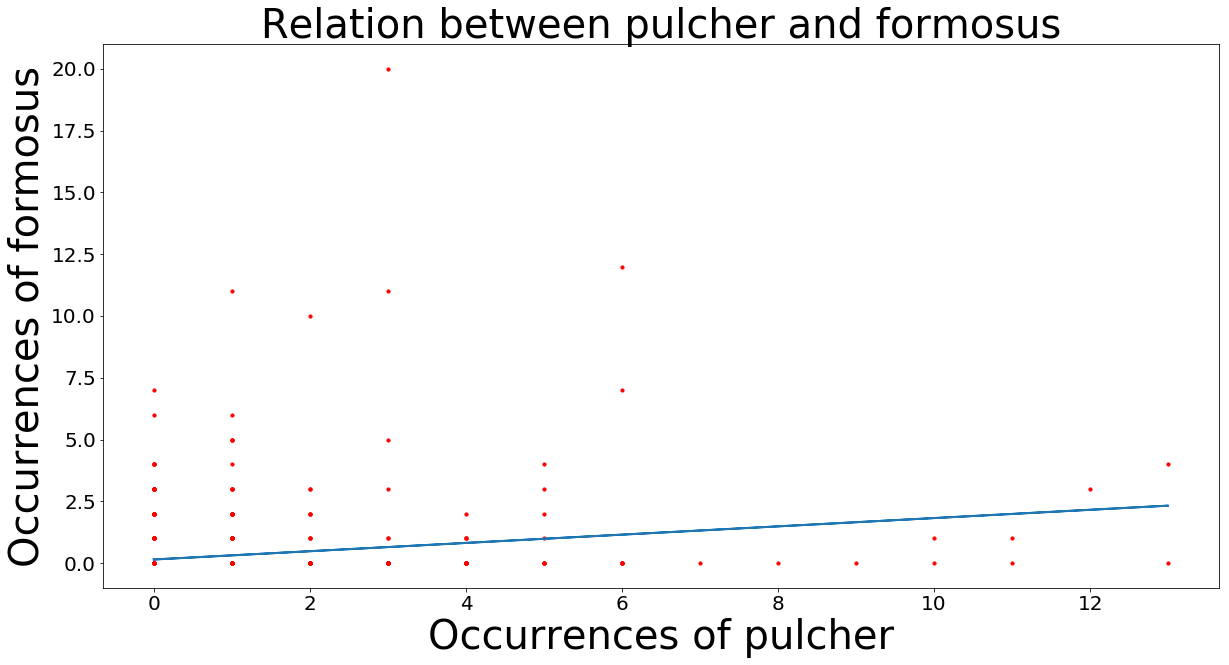

In [19]:
# строим график с прямой и записываем график в файл
plt.figure(figsize=(20, 10)) # размер в Jupyter Notebook-е
plt.scatter(x, y, s=10, c='red') # строим точки
plt.xlabel('Occurrences of pulcher', size=40) # название оси X и его размер
plt.ylabel('Occurrences of formosus', size=40) # название оси Y и его размер
plt.title('Relation between pulcher and formosus', size=40) # название таблицы и его размер
plt.plot(np.array(x), k * np.array(x) + b, linewidth=2) # рисуем прямую
plt.xticks(fontsize=20) # размер чисел на оси X
plt.yticks(fontsize=20) # размер чисел на оси Y
plt.savefig('relation.png', type="png", transparent=True, dpi=300) # сохраняем в файл
plt.show() # выводим на экран

Pulcher употребляется в среднем примерно в 4-5 раз чаще, чем formosus.

In [26]:
# заводим и заполняем словарь частотности конкретных словоформ
# убрал формы на que, т.к. они редко встречаются и "захламляют" график
d = dict()
for elem in paradigm1:
    if 'que' in elem:
        continue
    d[elem] = 0
for elem in paradigm2:
    if 'que' in elem:
        continue
    d[elem] = 0
    
for key, value in texts.items():
    tmp = value.split()
    for elem in paradigm1:
        if 'que' in elem:
            continue
        d[elem] += tmp.count(elem)
    for elem in paradigm2:
        if 'que' in elem:
            continue
        d[elem] += tmp.count(elem)
d

{'formosa': 86,
 'formosae': 25,
 'formosam': 44,
 'formosarum': 2,
 'formosas': 5,
 'formose': 10,
 'formosi': 15,
 'formosis': 16,
 'formoso': 9,
 'formosorum': 1,
 'formosos': 16,
 'formosum': 28,
 'formosus': 55,
 'pulcher': 111,
 'pulchra': 190,
 'pulchrae': 33,
 'pulchram': 53,
 'pulchrarum': 1,
 'pulchras': 16,
 'pulchri': 18,
 'pulchris': 20,
 'pulchro': 67,
 'pulchrorum': 5,
 'pulchros': 11,
 'pulchrum': 132}

In [27]:
# сортируем его по возрастанию
sorted_d = sorted(d.items(), key=operator.itemgetter(1))
x = []
y = []
for elem in sorted_d:
    x.append(elem[0])
    y.append(elem[1])

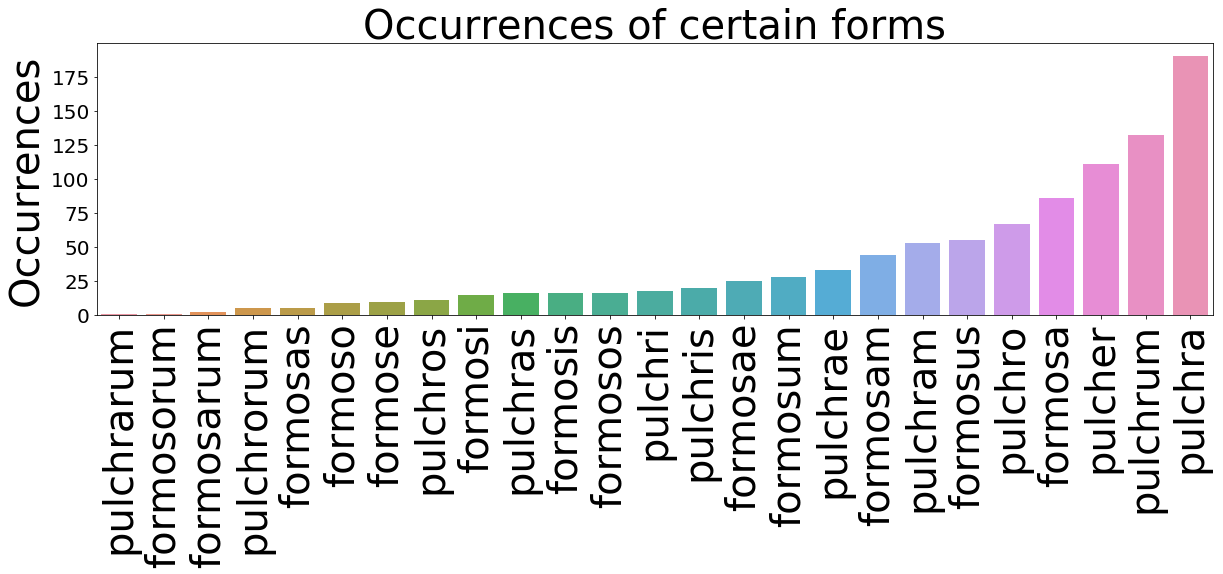

In [28]:
# рисуем график распределения конкретных словоформ
plt.figure(figsize=(20, 5)) # размер графика
barplot(x, y) # столбчатый граф
plt.title('Occurrences of certain forms', size=40) # название и его размер
plt.ylabel('Occurrences', size=40) # название оси Y и его размер
plt.xticks(rotation=90, size=40) # название оси X и его размер
plt.yticks(fontsize=20) # размер чисел на оси Y
plt.savefig("forms_and_occurrences.png", dpi=300, type="png", transparent=True, bbox_inches='tight', pad_inches=0) # сохранение в файл
plt.show() # вывод на экран

In [29]:
# объединяем все произведения в один текст и заводим словарь, где ключом является имя автора, а значением -- текст
dct = dict()
for key, value in texts.items():
    name = key.split('_')[0]
    if name in dct:
        dct[name] += ' ' + value
    else:
        dct[name] = value

In [39]:
# считаем кол-во вхождения того и другого прилагательного в случае полных текстов
# а также добавляем названия для точек
x = []
y = []
labels = []
for key, value in dct.items():
    tmp = value.split()
    sum1 = 0
    sum2 = 0
    for elem in paradigm1:
        if 'que' in elem:
            continue
        sum1 += tmp.count(elem)
    for elem in paradigm2:
        if 'que' in elem:
            continue
        sum2 += tmp.count(elem)
    x.append((sum1 / len(tmp)) * 1000000)
    y.append((sum2 / len(tmp)) * 1000000)
    labels.append(key)

In [40]:
x[labels.index('Varro')] # таким образом можно посмотреть конкретное значение

13.199054947665747

In [41]:
# строим прямую
regr = LR()
regr.fit(np.array(x).reshape(len(x), 1), np.array(y))
k, b = regr.coef_, regr.intercept_

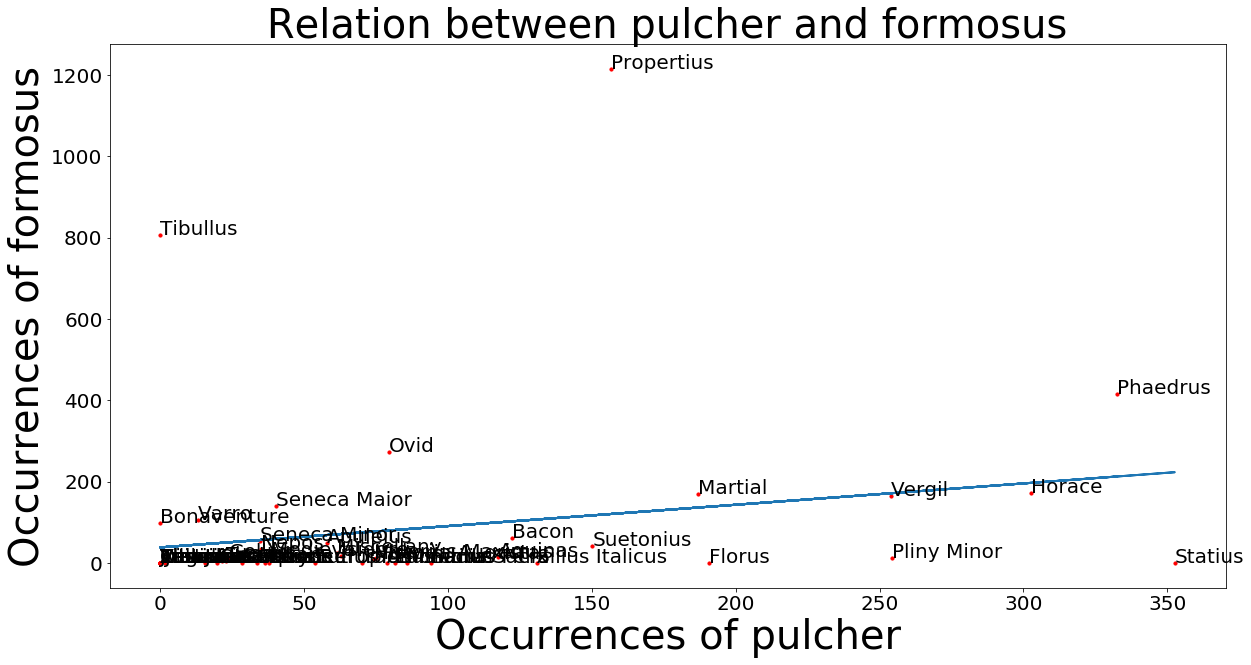

In [42]:
# строим график для авторов
plt.figure(figsize=(20, 10))
plt.scatter(x, y, s=10, c='red')
plt.xlabel('Occurrences of pulcher', size=40)
plt.ylabel('Occurrences of formosus', size=40)
plt.title('Relation between pulcher and formosus', size=40)
plt.plot(np.array(x), k * np.array(x) + b, linewidth=2)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i],y[i]), size=20) # добавляем название для каждой точки
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('relation_of_authors.png', type="png", transparent=True, dpi=300)
plt.show()

In [43]:
k # отрицательный или положительный наклон? положительный

array([ 0.52415453])

У Гнея Невия такое большое значение, т.к. в базе была всего одна его книга, где сравнительно часто употреблялось слово pulcher (2 раза). Писал много комедий.

У Секста Проперция 4 достаточно объёмные книги под названием "Элегии" (единственные его книги, дошедшие до нас). По-видимому, formosus было более "элегичным", более свойственно для такого жанра. Т.е. pulcher, по-видимому, было более обыденным, что ли. Хотя разница не такая значительная, как у Невия: в 2 раза.

Т.е. возникает гипотеза о том, что pulcher -- более приземлённое, чем formosus. Судя по значениям, такое ожидалось. Мы и в русском гораздо чаще говорим просто "хороший", чем какой-нибудь "изящный".

Альбий Тибулл (древнеримский поэт I века до н.э.): в 10 раз реже употребляет pulcher. 3 книги элегий.

У Федра, римского поэта-баснописца (переводил басни Эзопа и подражал им), немного чаще употребляется formosus. Басни Эзопа в 5 книгах. Это, конечно, не самый "примитивный" тип, но вполне можно представить, т.к. в баснях часто красочно описывают персонажей.

У Публия Овидия Назона примерно в 2 раза чаще употребляется formosus. В базе представлены как Метаморфозы и Героиды, так и Наука Любви и Любовные Элегии. Полагаю, что именно последний тип книг привёл к довольно значительному превосходству.

А теперь избавимся от них, чтобы повнимательнее посмотреть на левый нижний угол.

In [51]:
# удаляем "выбросы"
dct = dict()
for key, value in texts.items():
    name = key.split('_')[0]
    if name in ['Naevius', 'Propertius', 'Tibullus', 'Phaedrus', 'Ovid', 'Roman Epitaphs', 'Medieval', 'Statius']:
        continue
    if name in dct:
        dct[name] += ' ' + value
    else:
        dct[name] = value

In [52]:
# аналогичным образом заводим списки x и y
x = []
y = []
labels = []
for key, value in dct.items():
    tmp = value.split()
    sum1 = 0
    sum2 = 0
    for elem in paradigm1:
        if 'que' in elem:
            continue
        sum1 += tmp.count(elem)
    for elem in paradigm2:
        if 'que' in elem:
            continue
        sum2 += tmp.count(elem)
    x.append((sum1 / len(tmp)) * 1000000)
    y.append((sum2 / len(tmp)) * 1000000)
    labels.append(key)

In [53]:
# строим прямую
regr = LR()
regr.fit(np.array(x).reshape(len(x), 1), np.array(y))
k, b = regr.coef_, regr.intercept_

In [54]:
k # коэффициент наклона

array([ 0.34320057])

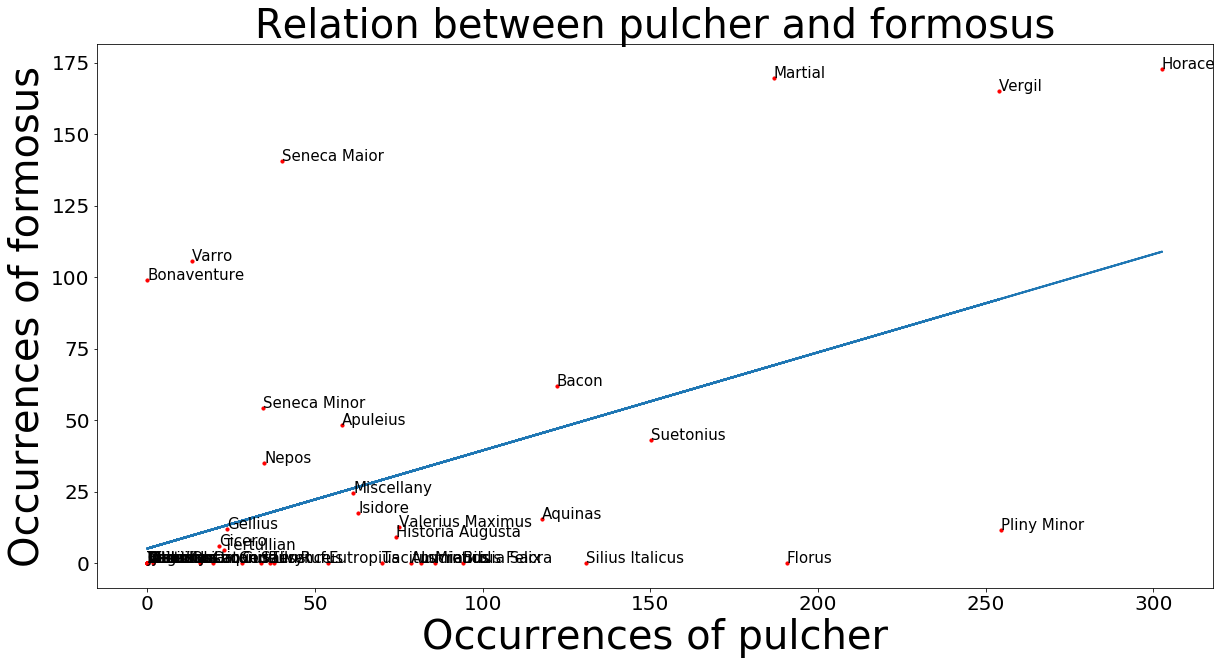

In [55]:
# строим график в этом случае
plt.figure(figsize=(20, 10))
plt.scatter(x, y, s=10, c='red')
plt.xlabel('Occurrences of pulcher', size=40)
plt.ylabel('Occurrences of formosus', size=40)
plt.title('Relation between pulcher and formosus', size=40)
plt.plot(np.array(x), k * np.array(x) + b, linewidth=2)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i],y[i]), size=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('relation_of_authors2.png', type="png", transparent=True, dpi=300)
plt.show()

Амвросий Медиоланский (337-397) -- миланский епископ, проповедник и гимнограф. Ну тоже ясно -- описывал всякие чудеса. Не до тривиального pulcher. de Mysteriis (о мистериях) Hymni (гимны) Epistula ad Sororem (письма к сестре/дочери) Epistulae Variae (письма правды)

Лу́ций Анне́й Се́нека -- древнеримский писатель-ритор. Большие "Прения", "Увещевательные или защитительные речи" и некоторые фрагменты.

Марк Теренций Варрон -- римский учёный-энциклопедист и писатель I века до н. э., по месту рождения именуемый Варрон Реатинский. "О латинском языке", "Сельское хозяйство" -- по-видимому из-за влияния первого труда. либо восхищался природой...

Бонавентура -- средневековый теолог, францисканский схоласт, генерал францисканского ордена, кардинал. (аналогичен первому священнику).

Луций Цецилий Фирмиан Лактанций — ритор из Африки, ученик Арнобия, принявший в 303 году христианскую веру. За образованность и красноречие Лактанций заслужил впоследствии от гуманистов эпохи Ренессанса почетное звание «христианского Цицерона». "О смерти гонителей", "Божественные установления".

Для всех остальных начинает преобладать pulcher.

Особенно это характерно для следующих писателей:

Авиан — римский поэт-баснописец начала V века. Под именем Авиана до нас дошло 42 басни в элегических дистихах с прозаическим вступлением в форме письма к некоему Феодосию. Противоречит другому баснописцу. Об этом нужно обязательно сказать.
Во вступлении к басням Авиан объясняет, чем привлек его этот жанр: «…пришел мне на ум басенный слог: ведь басни не чуждаются изящного вымысла и не обременяют непременным правдоподобием». Т.е. вымысел изящный, а вот слог не очень :)
Поэтика Авиана имеет установку на развлекательность, а не на поучение. Для его стиля характерны развёрнутые метафоры, цветистые эпитеты, заимствования целых выражений из Вергилия.

Гораций: ревнеримский поэт «золотого века» римской литературы. "Послания", "Песни", "Беседы". 

Авре́лий Пруде́нций Кле́мент — римский христианский поэт. "Восхваления христианских мучеников".

Публий Папиний Стаций — латинский поэт, современник Домициана, автор эпических поэм «Фиваида» и «Ахиллеида» и сборника «Сильвы». "Фиваида", "Сильвы" и "Ахиллеида".

Плиний Младший -- 10 писем и "Панегирики".

In [56]:
# удаляем ещё выбросы
dct = dict()
for key, value in texts.items():
    name = key.split('_')[0]
    if name in ['Naevius', 'Propertius', 'Tibullus', 'Phaedrus', 'Ovid', 'Roman Epitaphs', 'Medieval', 'Statius', 'Ambrosius', 'Seneca Maior', 'Varro', 'Bonaventure', 'Lactantius', 'Avianus', 'Horace', 'Prudentius', 'Statius', 'Pliny Minor']:
        continue
    if name in dct:
        dct[name] += ' ' + value
    else:
        dct[name] = value

In [57]:
x = []
y = []
labels = []
for key, value in dct.items():
    tmp = value.split()
    sum1 = 0
    sum2 = 0
    for elem in paradigm1:
        if 'que' in elem:
            continue
        sum1 += tmp.count(elem)
    for elem in paradigm2:
        if 'que' in elem:
            continue
        sum2 += tmp.count(elem)
    x.append((sum1 / len(tmp)) * 1000000)
    y.append((sum2 / len(tmp)) * 1000000)
    labels.append(key)

In [58]:
regr = LR()
regr.fit(np.array(x).reshape(len(x), 1), np.array(y))
k, b = regr.coef_, regr.intercept_

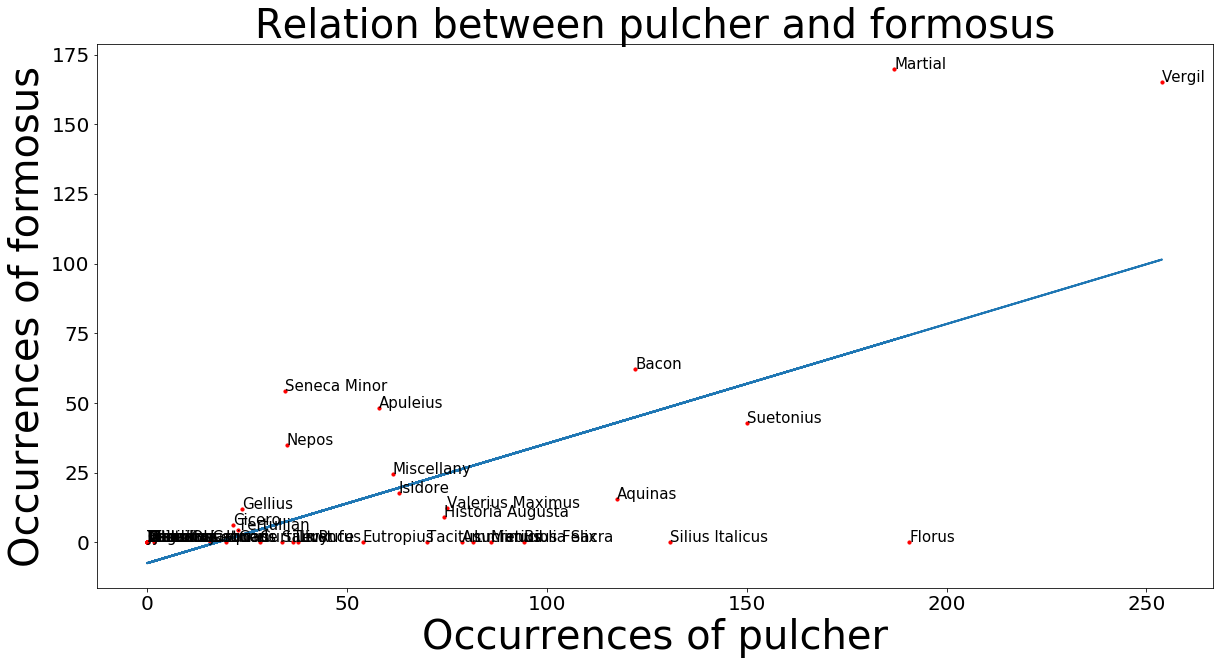

In [59]:
# строим и в этом случае
plt.figure(figsize=(20, 10))
plt.scatter(x, y, s=10, c='red')
plt.xlabel('Occurrences of pulcher', size=40)
plt.ylabel('Occurrences of formosus', size=40)
plt.title('Relation between pulcher and formosus', size=40)
plt.plot(np.array(x), k * np.array(x) + b, linewidth=2)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i],y[i]), size=15)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.savefig('relation_of_authors3.png', type="png", transparent=True, dpi=300)
plt.show()

вывод: formosus -- что-то необычное, свойственное элегиям и всему поэтическому, а pulcher -- более приземлённое.

In [60]:
sorted(dct.keys()) # авторы

['Ammianus',
 'Apuleius',
 'Aquinas',
 'Augustus',
 'Bacon',
 'Biblia Sacra',
 'Caesar',
 'Cicero',
 'Claudian',
 'Curtius Rufus',
 'Disticha Catonis',
 'Eutropius',
 'Florus',
 'Frontinus',
 'Gellius',
 'Historia Augusta',
 'Isidore',
 'Julius Obsequens',
 'Justin',
 'Justinian',
 'Livy',
 'Lucan',
 'Lucretius',
 'Martial',
 'Minucius Felix',
 'Miscellany',
 'Nepos',
 'Sallust',
 'Seneca Minor',
 'Silius Italicus',
 'Suetonius',
 'Tacitus',
 'Terence',
 'Tertullian',
 'Theodosian Code',
 'Valerius Maximus',
 'Velleius',
 'Vergil',
 'Vitruvius']

In [58]:
# с помощью этого кода можно записать тексты в файл
with open('texts2.txt', 'w', encoding='utf-8') as f:
    json.dump(texts, f)

In [12]:
# с помощью этого кода можно считать тексты из файла
with open('texts.txt', 'r', encoding='utf-8') as f:
    texts = json.load(f)